In [1]:
# Data Loader
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
import pytorch_lightning as pl
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
import json
from CustomDataset import * 
import sys
sys.path.append('../')
from config import *
from file_helper import *

def collate_fn(batch):
    return tuple(zip(*batch))
#=================================
#             Augmentation
#=================================

def gauss_noise_tensor(img):
    rand = torch.rand(1)[0]
    if rand < 0.5 and Horizon_AUG:
        sigma = rand *0.125
        out = img + sigma * torch.randn_like(img)
        return out
    return img

def blank(img):    
    return img

class CustomDataModule(pl.LightningDataModule):
    def __init__(self ,
                 train_dir ,
                 test_dir , batch_size = 2, num_workers = 0 , img_size=[IMG_WIDTH, IMG_HEIGHT] , use_aug = True ,padding_count = 24 ,c =0.1
                   ):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size      
        self.use_aug = use_aug
        self.padding_count  = padding_count
        self.c = c
        

        pass

    def prepare_data(self) -> None:
        # Download dataset
        pass

    def setup(self, stage):
        # Create dataset...          
                
        self.entire_dataset = CustomDataset(self.train_dir  , use_aug= self.use_aug , padding_count= self.padding_count , c=self.c , img_size=self.img_size)
        self.train_ds , self.val_ds = random_split(self.entire_dataset , [0.9, 0.1])        
        self.test_ds = CustomDataset(self.test_dir  , use_aug= False , img_size=self.img_size)
        
        print("image size ",self.img_size)
        pass

    # ToDo: Reture Dataloader...
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self.train_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=True)
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.val_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=False)
    
    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.test_ds , batch_size= self.batch_size , num_workers= self.num_workers , shuffle=False)

    pass


# Test
dm = CustomDataModule ( train_dir= f"../anno/test_visiable_10_no_cross.json" ,
                       test_dir= f"../anno/test_visiable_10_no_cross.json" , padding_count=256, img_size=[512,256]
                       )


e:\Projects\Layout\ours
e:\Projects\Layout\Horizon_and_SAM\Horizon


In [2]:
from torch import Tensor
def unpad_data( x :[Tensor] ) :
	non_zero_indices = torch.nonzero(x)
	#print(non_zero_indices)
	# Get the non-zero values
	non_zero_values = x[non_zero_indices[:,0], non_zero_indices[:,1]]

	unique = torch.unique(non_zero_indices[:,0] ,return_counts=True)	
	non_zero_values = torch.split(non_zero_values , tuple(unique[1]))
	
	return non_zero_values

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type               | Params
--------------------------------------------------------
0 | pe               | PositionalEncoding | 0     
1 | encoder          | TransformerEncoder | 67.2 M
2 | pixel_value_proj | Conv2d             | 1.2 M 
3 | mlp    

image size  [256, 128]


Training: 0it [00:00, ?it/s]

return_weight True
return_weight True
return_weight True
return_weight True
return_weight True
return_weight True
return_weight True
return_weight True


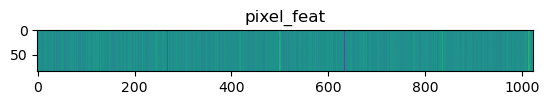

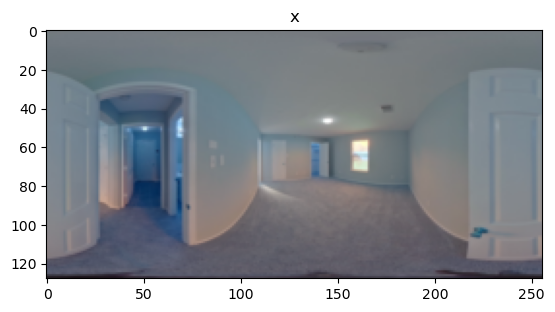

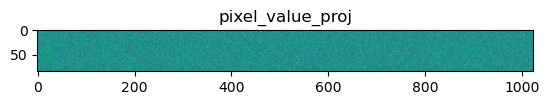

8
torch.Size([85, 5, 5])
torch.Size([85, 5, 5])


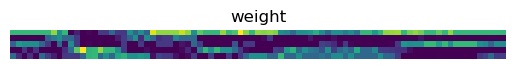

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 256, 3)


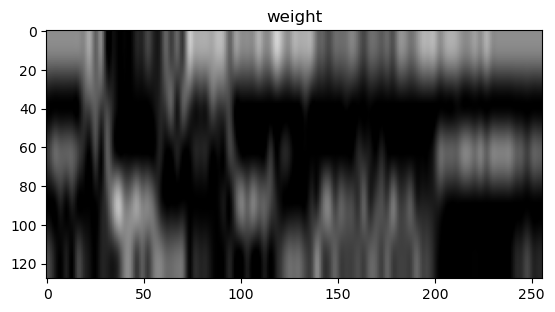

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


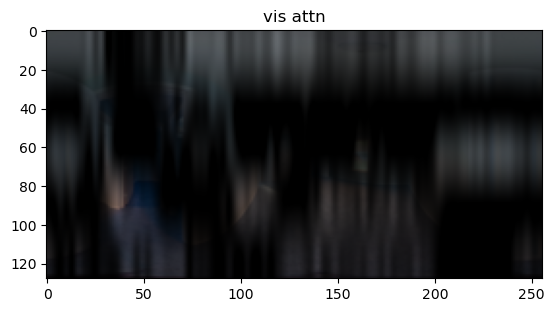

`Trainer.fit` stopped: `max_steps=1` reached.


In [74]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import Any
import pytorch_lightning as pl
from config import *
import torchvision.models as models
from torchvision.ops import MLP
import math
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from VerticalCompressionNet import * 
from CustomTransformer import *

def encode_target(box_b , base_u):
    box_b[:, 1] = (0.5 -box_b[:, 1])  # v top
    box_b[:, 2] = (box_b[:, 2] -0.5) # v btm
    #box_b[:, 3] = ( box_b[:, 3] + base_u) # du
    box_b[:, 3] = box_b[:, 3] # du

    box_b[:, 4] = (0.5 -box_b[:, 4])  # v top
    box_b[:, 5] = (box_b[:, 5] -0.5) # v btm
    box_b[:, 0] = (base_u - box_b[:, 0])  # u
    '''
    box_b[:, 1] = torch.exp(torch.abs(0.5 -box_b[:, 1]))  # v top
    box_b[:, 2] = torch.exp(torch.abs(box_b[:, 2] -0.5)) # v btm
    box_b[:, 3] = torch.exp(torch.abs(box_b[:, 3])) # du

    box_b[:, 4] = torch.exp(torch.abs(0.5 -box_b[:, 4]))  # v top
    box_b[:, 5] = torch.exp(torch.abs(box_b[:, 4] -0.5)) # v btm
    box_b[:, 0] = torch.exp( box_b[:, 0] )  # u
    '''

    return box_b
def decode_target(box_b , base_u):    
    box_b[:, 0] = base_u - box_b[:, 0]  # u
    box_b[:, 1] = 0.5 - box_b[:, 1]  # v top
    box_b[:, 2] = box_b[:, 2] +0.5 # v btm
    box_b[:, 3] = base_u + box_b[:, 3]  # du

    box_b[:, 4] = 0.5 -box_b[:, 4]  # v top    
    box_b[:, 5] = box_b[:, 5] +0.5 # v btm
    '''
    box_b[:, 0] = torch.log( box_b[:, 0] )  # u
    box_b[:, 1] = 0.5 - torch.log(box_b[:, 1])  # v top
    box_b[:, 2] = torch.log(box_b[:, 2]) +0.5 # v btm
    box_b[:, 3] = torch.log(box_b[:, 3]) + box_b[:, 0] # du

    box_b[:, 4] = 0.5 - torch.log(box_b[:, 4])  # v top    
    box_b[:, 5] = torch.log(box_b[:, 4]) +0.5 # v btm
    '''
    return box_b

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: 256, dropout: float = 0.1, max_len: int = 1024):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, d_model: 256, nhead: int , d_hid: int, nlayers: int, dropout: float = 0.1 , activation="relu" ,
                  normalize_before=False , out_dim=20 ,channel = 1024):
        super().__init__()
        #self.ntoken = ntoken
        self.model_type = 'Transformer'
        self.d_model = d_model
        self.out_dim =out_dim
       
        self.enc_proj = nn.Linear(channel , self.out_dim * 4)
        
        self.cls_head = nn.Linear(channel, 1 )
        self.u_head = nn.Linear(channel, 2 )
        self.v_head = nn.Linear(channel, 4 )

        self.u_head.bias.data.fill_(self.out_dim /100*0.5)
        self.v_head.bias.data.fill_(0.15)

        
    
        
    def forward(self, src: Tensor ) -> Tensor:
        # permute to (Sequence_length , Batches , Hidden layer)
        '''
        plt.imshow(src[0].detach().cpu().numpy())
        plt.title("src")
        plt.show()
        '''
        src         = src.permute(2,0,1)   #  [w, b, c*h]  , example: [256 , 5 , 1024]        
        #src         = src.permute(1 , 0 , 2)# torch.Size([1024, b, 256])        
        batch_size  = src.shape[1]   
        '''
        src_pe         = self.pe(src)   # [ 256 , b , hidden_dim]
        #print("src_pe",src_pe.shape)
        src_pe         = self.encoder(src_pe) # [ 256 , b , hidden_dim]
        '''     
        src_pe         = self.enc_proj(src) # [ 256 , b , max count * 4
        src_pe         = src_pe.view(src_pe.shape[0], src_pe.shape[1], self.out_dim , 4) # [ 256 , b , max count * 4
        #src_pe         = src_pe.permute(1,0,2)  # [b , width , 1024]
        out = src_pe.permute(1 , 2 , 0, 3)  # [b, max_count , seq_len, step_cols]
        out = out.contiguous().view(out.shape[0] , self.out_dim , -1) 

        #print(src_pe.shape)
        #plt.imshow(src_pe[0].detach().cpu().numpy())
        #plt.title("encoder output")
        #plt.show()
        #print("self.query_embed.weight " , self.query_embed.weight .shape)
        #out = self.decoder( self.query_embed.weight , src_pe)
        '''
        out = self.decoder1(src_pe)        
        out = torch.relu(out)
        out = self.decoder2(out)        
        out = torch.relu(out)
        out = self.decoder3(out)        
        out = torch.relu(out)
        '''
        #print("out",src_pe.shape)        
       
        box_u_logits = self.u_head(out)
        box_v_logits = self.v_head(out)
        cls_logits = self.cls_head(out)
        
        #print("box_v_logits" , box_v_logits.shape)
        box_logits = torch.cat([ box_u_logits[:,:,0].unsqueeze(2) ,
                                 box_v_logits[:,:,0].unsqueeze(2) ,
                                 box_v_logits[:,:,1].unsqueeze(2) , 
                                 box_u_logits[:,:,1].unsqueeze(2) ,
                                 box_v_logits[:,:,2].unsqueeze(2) ,
                                 box_v_logits[:,:,3].unsqueeze(2)] , dim=-1 )
        #print("box_logits" , box_logits.shape)
        return box_logits ,cls_logits



    

class VerticalQueryTransformer(pl.LightningModule):    
    def __init__(self  ,  max_predict_count = 24 ,
                    hidden_out = 128 , class_num = 1 ,
                    log_folder = "__test" , num_classes = 1 , 
                    backbone_trainable =False, load_weight =""  ,
                    dropout = 0.01 , normalize_before=False
                    ,stride = 3,
                    img_size = [1024,512]):
        #print(" input_size" ,  input_size)
        super().__init__()
        self.confidence_threshold = 0.75
        self.log_folder = create_folder(os.path.join(os.getcwd() , "output" , log_folder))
        self.automatic_optimization = False
        self.hidden_size = hidden_out
        self.max_predict_count = max_predict_count
        self.num_classes  = num_classes 

        self.input_width = img_size[0]
        self.input_height = img_size[1]
        self.stride=stride
        self.patch_out =  self.input_width//self.stride
        

        #self.pixel_value_proj = nn.Linear( 3*self.input_height , self.hidden_size )

        self.pe = PositionalEncoding(self.hidden_size ,dropout , max_len=  self.input_width)
        encoder_norm = nn.LayerNorm(self.hidden_size) if normalize_before else None
        encoder_layer = TransformerEncoderLayer(self.hidden_size, 8, 2048,
                                                dropout, 'relu', normalize_before)
        self.encoder = TransformerEncoder(encoder_layer, 8, encoder_norm )
        '''
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.hidden_size, nhead=8, dropout=dropout, activation='relu', batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        '''

        #decoder_layer = nn.TransformerDecoderLayer(d_model=self.hidden_size, nhead=8  )
        #self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)


        #self.backbone = Resnet()

        #self.pos_emb = nn.Embedding(self.max_predict_count , self.hidden_size)
        self.pos_emb = nn.Parameter(torch.randn(size=(1,  self.patch_out, hidden_out)), requires_grad=True)
        #nn.init.constant_(self.pos_emb.weight , 0)
        #self.pixel_query = nn.Linear(self.input_width , self.hidden_size , kernel_size=3 , padding=1)
        #self.pixel_query = nn.Linear(self.hidden_size , self.hidden_size )
        self.pixel_value_proj =nn.Conv2d(
                in_channels= 3 ,
                out_channels=hidden_out,
                kernel_size= (self.input_height , stride),
                stride= (self.input_height , stride),
            )
        self.mlp = MLP(hidden_out , [hidden_out//2 , hidden_out//4 ,hidden_out//8 , hidden_out//16 ])

        self.cls_head = nn.Linear(self.hidden_size//16 , 1 )
        self.u_head = nn.Linear(self.hidden_size//16, 2 )
        self.v_head = nn.Linear(self.hidden_size//16, 4 )

        self.u_head.bias.data.fill_(1 /self.patch_out*0.5)
        self.v_head.bias.data.fill_(0.25)

    def forward(self ,x ):
        #x = self.backbone(x)[-1] 
        #x = x.permute(0,3,1,2)  # [ batch , width , channel , height]
        #x = x.view(x.shape[0] , x.shape[1] , -1)  # [ batch , width , channel * height]        
        
        pixel_feat = self.pixel_value_proj(x)  # [ batch , hidden , height(=1) , patches ]
        pixel_feat = pixel_feat.flatten(2).permute(0,2,1)   # [ batch , patches ,hidden ]
        
        src_pe =  pixel_feat + self.pos_emb  # [ batch , patches ,hidden ]
        src_pe =  self.pe(src_pe)
        
        #enc_out = self.encoder(src_pe)     
        enc_out , weight = self.encoder(src_pe , return_weight= True )     
        if(self.global_step %10 ==0):
            '''
            '''
            plt.imshow(pixel_feat[0].detach().cpu().numpy())
            plt.title("pixel_feat")
            plt.show()

            plt.imshow(x[0].permute(1,2,0).detach().cpu().numpy())
            plt.title("x")
            plt.show()
            '''
            '''            
            plt.imshow(self.pos_emb[0].detach().cpu().numpy())
            plt.title("pixel_value_proj")
            plt.show()
            '''
            '''           
            print(len(weight) )
            print(weight[0].shape) 
            print(weight[-1].shape)  # [85, 5, 5]
            plt_weight = np.array(weight[0].permute(1,0,2)[0].transpose(1,0).detach().cpu().numpy())
            
            fig, ax = plt.subplots(1, 1)            
            ax.imshow(plt_weight)
            plt.title("weight")
            plt.axis("off")
            plt.show()

            w = cv2.resize(plt_weight , dsize= (self.input_width ,self.input_height ) , interpolation=cv2.INTER_CUBIC)
            #fill = np.ones_like(w)
            #w = np.dstack([fill, fill,fill, w])         
            w = np.dstack([w , w , w])         
            print(w.shape) 
            plt.imshow(w)
            plt.title("weight")
            plt.show()
            
            plt.imshow(x[0].permute(1,2,0).detach().cpu().numpy() * w )
            plt.title("vis attn")
            plt.show()
            
            '''
            print(self.encoder.state_dict().keys())
            for n, p in self.encoder.named_parameters():
                if "self_attn.in_proj_weight" in n:
                    encoder_weight = self.encoder.state_dict()[n]
                    print("self.pe.weight" ,encoder_weight.shape)
                    plt.imshow(encoder_weight.detach().cpu().numpy())
                    plt.title(n)
                    plt.show()

                    a = src_pe * encoder_weight
                    plt.imshow(a.detach().cpu().numpy())
                    plt.title(n)
                    plt.show()
            '''

        #src_pe = src_pe.permute(1,0,2)  # [sequence length, batch size, embed dim]
        
        #src_pe = self.pe(pixel_feat) * math.sqrt(self.hidden_size)
        #print("src_pe  " , src_pe.shape)
        #enc_out,atten_weight = self.encoder(src_pe , return_weight =True)        
    
        
        
        enc_out = self.mlp(enc_out)
        box_u_logits = self.u_head(enc_out)
        box_v_logits = self.v_head(enc_out)
        cls_logits = self.cls_head(enc_out)
        
        box_logits = torch.cat([ box_u_logits[:,:,0].unsqueeze(2) ,
                                 box_v_logits[:,:,0].unsqueeze(2) ,
                                 box_v_logits[:,:,1].unsqueeze(2) , 
                                 box_u_logits[:,:,1].unsqueeze(2) ,
                                 box_v_logits[:,:,2].unsqueeze(2) ,
                                 box_v_logits[:,:,3].unsqueeze(2)] , dim=-1 )
        
        return box_logits ,cls_logits            

        return out_box , out_cls
    
    @torch.no_grad()
    def inf(self , imgs ):
        
        out_box , out_cls   = self.forward(imgs)  # [ batch , top_k , 5]   , [ batch , top_k , 1]         
        #print("val " , out_cls)
        #print("val sigmoid" , torch.sigmoid(out_cls))
        
        batch_size = out_box.shape[0]
        #sampled_u_idx = torch.argwhere( torch.sigmoid(out_cls.view(batch_size , -1)) > 0.01 )
        #print("sampled_u_idx" , sampled_u_idx)

        sampled_box_b = []
        #each batch
        for img , pred , pcls in zip(imgs, out_box , out_cls.view(batch_size,-1)):  
            u_id = torch.argwhere(torch.sigmoid(pcls) > self.confidence_threshold)
            print("u_id"  , u_id)
            if(u_id.numel() ==0):
                continue
            u_id = u_id.view(-1)            
            
            #pred = self.post_process(pbox[u_id,:] , u_id ).view(-1,6)
            pred = pred[u_id]
            
            save_folder = create_folder( os.path.join(self.log_folder ,"val"))
            save_path = os.path.join(save_folder, f"val_ep_{self.current_epoch}-{self.global_step}" )

            decode_pred = decode_target(pred.clone())
            #pred_us , pred_tops , pred_btms = self.pack_visualize(pred[:,0], pred[:,1],pred[:,2],pred[:,3] -pred[:,0] ,pred[:,4],pred[:,5] )                    
            pred_us , pred_tops , pred_btms = self.pack_visualize(decode_pred[:,0], decode_pred[:,1],decode_pred[:,2],decode_pred[:,3] ,decode_pred[:,4],decode_pred[:,5] )                    
            vis_imgs = visualize_2d_single(pred_us , pred_tops , pred_btms , u_grad = F.sigmoid(pcls).view(1 , -1 ) , imgs=  img , title="Pred" , save_path= save_path  )
            #plt.imshow(vis_imgs)
            #plt.show()

            # ToDo: calculate loss          
        
    @torch.no_grad()
    def pack_visualize(self, gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , dv_btm_b ):
        
        if isinstance(gt_u_b, torch.Tensor):
            sizes = [t.numel() for t in gt_u_b]               
            us = gt_u_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            us[1::2]+=gt_du_b.flatten()
            us = torch.split(us.view(-1,2) , sizes)

            tops = gt_vtop_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            tops[1::2]=gt_dvtop_b.flatten()
            tops = torch.split(tops.view(-1,2) , sizes)

            btms = gt_vbtm_b.flatten().unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            btms[1::2]=dv_btm_b.flatten()
            btms = torch.split(btms.view(-1,2) , sizes)

        elif isinstance(gt_u_b, tuple) and all(isinstance(t, torch.Tensor) for t in gt_u_b):        
            sizes = [len(t) for t in gt_u_b]               
            us = torch.cat(gt_u_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            us[1::2]+=torch.cat(gt_du_b).view(-1)
            us = torch.split(us.view(-1,2) , sizes)

            tops = torch.cat(gt_vtop_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            tops[1::2]=torch.cat(gt_dvtop_b).view(-1)
            tops = torch.split(tops.view(-1,2) , sizes)

            btms = torch.cat(gt_vbtm_b).view(-1).unsqueeze(0).repeat(2, 1).permute(1,0).reshape(-1)
            btms[1::2]=torch.cat(dv_btm_b).view(-1)
            btms = torch.split(btms.view(-1,2) , sizes)
        else:
            assert("Wrong Type.")
        
        return us , tops ,btms
        
        pass

    def training_step(self , input_b ,batch_idx ):
        
        img = input_b['image']        
        out_box , out_cls   = self.forward(img)  # [ batch , top_k , 5]   , [ batch , top_k , 1] 
        #print("max out_cls" , torch.max(out_cls) , "min " , torch.min(out_cls))
        batch_size = out_box.shape[0]
        
        # remove padding , each batch have different length
        gt_u_b = unpad_data( input_b['u'])          
        gt_vtop_b =unpad_data(input_b['v_top'])
        gt_vbtm_b = unpad_data (input_b['v_btm'])
        gt_du_b = unpad_data(input_b['du'])
        gt_dvtop_b = unpad_data(input_b['dv_top'])
        gt_dv_btm_b = unpad_data(input_b['dv_btm'])
        
        total_loss = 0
        b_cnt = 0        
        
        for u,vtop,vbtm,du,dvtop, dvbtm , pred ,cls_b , gt_grad_cls  in zip(gt_u_b , gt_vtop_b , gt_vbtm_b , gt_du_b , gt_dvtop_b , gt_dv_btm_b , out_box , out_cls ,input_b['u_grad'] ):
            
            # match                        
            gt_box =  torch.vstack([ u, vtop,vbtm,  du ,dvtop , dvbtm]).permute(1,0)   # [n , 6]
            #print("gt_box" , gt_box)
            u_grad = (torch.arange(self.patch_out,device=u.device).unsqueeze(-1) /self.patch_out ).view(-1)
            #gt_cloest_u = u / self.patch_out
            decode_pred_b = decode_target(pred.clone() , u_grad)
            
            

            u_cost = torch.cdist( (torch.arange(self.patch_out,device=u.device).unsqueeze(-1) /self.patch_out ) , u.unsqueeze(-1) )                        
            #box_loss = torch.cdist( pred , gt_box , p=1)
            #box_loss = torch.cdist( pred , encode_gt_b , p=1)
            #box_loss = torch.cdist( decode_pred_b , gt_box , p=1)
            cls_cost = -torch.sigmoid(cls_b)
            
            #cost_matrix = box_loss  + cls_cost  + u_cost
            #cost_matrix =  cls_cost  + u_cost*3
            cost_matrix =  cls_cost + u_cost * 2
            #cost_matrix = u_cost
            
            
            cost_matrix = cost_matrix.detach().cpu().numpy()            
            row_idx  , col_idx = linear_sum_assignment(cost_matrix)    
            matched_u = torch.tensor( np.float32(row_idx)/self.patch_out,device=u.device)

            encode_gt_b = encode_target(gt_box.clone()  , matched_u)
            '''
            print("matched u" , row_idx / self.patch_out )
            print("pred" , pred[row_idx])
            print("decode_pred_b",decode_pred_b[row_idx])
            print("encode_gt_b",encode_gt_b[col_idx])
            print("gt" , gt_box[col_idx])
            '''
            
            gt_cls = torch.zeros(self.patch_out,device= cls_b.device )            
            gt_cls[row_idx] = 1            
            
            #gt_l1_target = encode_target(gt_box.clone() , matched_u)           
            
            #decode_pred = decode_target(pred.clone()[row_idx].view(-1,6) , matched_u)
            #decode_pred = pred.clone()[row_idx].view(-1,6)   # debug
            #l1_loss = F.l1_loss(decode_pred ,  gt_l1_target[col_idx]) 
            l1_loss = F.l1_loss(pred[row_idx] ,  encode_gt_b[col_idx]) 
            #l1_loss = F.l1_loss(decode_pred_b[row_idx] ,  gt_box[col_idx]) 
            #cls_loss = F.binary_cross_entropy_with_logits(cls_b.view(-1), gt_cls.view(-1)) 
            cls_loss = F.binary_cross_entropy_with_logits(cls_b.view(-1), gt_grad_cls) 
            #cls_loss = F.binary_cross_entropy_with_logits(cls_b.view(-1)[cls_sample_idx], gt_cls.view(-1)[cls_sample_idx]) 
            #print("cls_b" , cls_b.view(-1))
            #print("gt_cls" , gt_cls.view(-1))
            #print("pred box" , decode_pred)
            #print("gt box" , gt_box[col_idx])

            #print("L1 loss"  , l1_loss)
            #print("cls_loss"  , cls_loss)
            
            total_loss += l1_loss + cls_loss*5
            #total_loss += cls_loss
                        
            with torch.no_grad():
                #if self.current_epoch % 5 == 0  :                
                #if self.current_epoch % 5 == 0 and self.current_epoch > 0 and batch_idx<2 :                
                if self.current_epoch > 0 and batch_idx <5 :                
                    save_path =  os.path.join(self.log_folder , f"gt_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )
                    
                    gt_us , gt_tops , gt_btms = self.pack_visualize(u.view(1 , -1 ) , vtop , vbtm , du , dvtop , dvbtm )
                    

                    #vis_imgs = visualize_2d_single(gt_us , gt_tops , gt_btms , u_grad =  gt_cls.view(1 , -1 ), imgs= img[b_cnt] , title="GT",save_path=save_path )                
                    vis_imgs = visualize_2d_single(gt_us , gt_tops , gt_btms , u_grad =  gt_grad_cls.view(1 , -1 ), imgs= img[b_cnt] , title="GT",save_path=save_path )                
                    
                    decode_pred = decode_pred_b[row_idx]
                    
                    save_path =  os.path.join(self.log_folder , f"pred_ep_{self.current_epoch}-{self.global_step}-{batch_idx}" )
                    #decode_pred = decode_target(pred.clone()[row_idx].view(-1,6) , matched_u)
                    #pred_us , pred_tops , pred_btms = self.pack_visualize(pred[row_idx,0], pred[row_idx,1],pred[row_idx,2],pred[row_idx,3] ,pred[row_idx,4],pred[row_idx,5] )                    
                    pred_us , pred_tops , pred_btms = self.pack_visualize(decode_pred[:,0], decode_pred[:,1],decode_pred[:,2],
                                                                          decode_pred[:,3]-decode_pred[:,0] ,
                                                                          decode_pred[:,4],decode_pred[:,5] )                    
                    vis_imgs = visualize_2d_single(pred_us , pred_tops , pred_btms , u_grad = F.sigmoid(cls_b).view(1 , -1 ) , imgs=  img[b_cnt] ,
                                                    title=f"Pred_row{row_idx}-\n u:{pred_us}" , save_path= save_path  )
                    
                    #plt.imshow(vis_imgs)
                    #plt.show()
           
            b_cnt+=1
            pass        
        
        op1  = self.optimizers()
        op1.zero_grad()        
        self.manual_backward(total_loss / batch_size)
        op1.step()

        return total_loss / batch_size
        pass    

    def __validation_step(self, input_b, batch_idx):
        print("val!!!!!")
        img = input_b['image']
        
        #out_box , out_cls   = self.forward(img)  # [ batch , top_k , 5]   , [ batch , top_k , 1]         
        if(batch_idx %2==0 and self.current_epoch>0 ):
            self.inf(img)
        return
        

    def configure_optimizers(self):
        '''
        backbone_opt = optim.Adam(self.backbone.parameters() , lr=0.00035)
        comp_opt = optim.Adam(self.reduce_height_module.parameters() , lr=0.00035)
        transforms_opt = optim.Adam(self.transformer.parameters() , lr=0.00035)
        '''
        opt = optim.Adam(self.parameters() , lr=0.00035)

        return [opt] , []


    pass

# Unit testing...
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "detr_v1_d20_e50.pth")

img_size=[256, 128] 
# Test
dm = CustomDataModule ( train_dir= f"../anno/train_visiable_20_no_cross.json" ,
                        test_dir= f"../anno/test_visiable_10_no_cross.json" ,
                          padding_count=85 , use_aug=False , c= 0.65,batch_size=5 ,
                          img_size=img_size
                       )

#m = VerticalQueryTransformer(max_predict_count = 20 , hidden_out=256 , load_weight="D:/OneDrive/OneDrive - NTHU/Layout/Horizon/0912_all_bk.pth"  , backbone_trainable=True)
m = VerticalQueryTransformer(max_predict_count = 100 , hidden_out=1024 ,img_size=img_size  , backbone_trainable=True ,dropout=0)

'''
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "detr_v1_d20_e50.pth")
m = torch.load(save_file)
          
'''


save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
#save_file = os.path.join(save_path , "detr_v9_d20_e200_bugfix_pe_overfit.pth")
save_file = os.path.join(save_path , "detr_v9_d20_e200_bugfix_pe_customAtten.pth")
m.load_state_dict(torch.load(save_file) , strict=False)

trainer = pl.Trainer(accelerator='gpu' , devices=1 ,
                     min_epochs=1, max_epochs=201 , precision=16 , fast_dev_run=True )
trainer.fit(m , dm)



In [24]:
#a = torch.rand(2,3,512,1024)
a = torch.rand(2,3,512)
c = MLP(512 , [512,256,128])
#c = nn.Conv2d(in_channels= 3, out_channels= 256 , kernel_size=(512,1) , stride=(512,1))

b = c(a)
print(b.shape)

torch.Size([2, 3, 128])


In [ ]:
a = torch.rand(1,5,8)
self_attn = nn.MultiheadAttention(8, 8, dropout=0.1)
atten , src = self_attn(a  , a, a)

print(atten.shape) 	# ([20, 5, 256])
print(src.shape) 	# ([5, 20, 20])
plt.imshow(src[0].detach().cpu().numpy())
plt.show()

plt.imshow(atten.permute(1,0,2)[0].detach().cpu().numpy())
plt.show()

print(atten)
print(src)

In [51]:
save_path = create_folder( os.path.join(os.getcwd() , "output" , "checkpoints"))
save_file = os.path.join(save_path , "detr_v9_d20_e200_bugfix_pe_customAtten.pth")
#torch.save(m , save_file)
torch.save(m.state_dict(), save_file)

In [ ]:
#a = torch.rand(1,5,8)
a = torch.arange(80.0).view(2,5,8)
n = nn.Linear(8,2)
n.bias.data.fill_(1)
n.weight.data.fill_(1)

print(n.weight.shape)
print(n.bias)
b =n(a)
print(a)
print(b.shape)
print(b)

In [ ]:
a= torch.rand(20,2)
b = torch.rand(20)*2
b = b.to(torch.long).view(-1,1)
#c = a[b]
c= torch.gather(a,1,b)
print(c.shape)
print(a)
print(b)
print()
print(c)

In [ ]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(10, 32, 512)
tgt = torch.rand(20, 32, 512)
out = transformer_decoder(tgt, memory)
print(out.shape)

In [ ]:
import torch
horizon_path =r"D:/OneDrive/OneDrive - NTHU/Layout/Horizon/0912_all_bk.pth"
#models_dict = torch.load_s
checkpoint = torch.load(horizon_path ,  map_location="cpu")
print(checkpoint['state_dict'].keys())
#model.load_state_dict(checkpoint['model_state_dict'])
pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in m.state_dict()}
m.load_state_dict(pretrained_dict , strict=False)

In [ ]:
a= torch.rand(2,256 ,1024)
b = nn.Conv1d(256 , 64 , kernel_size=3 ,padding=1)
c = b(a)
print(c.shape)


In [ ]:
a = torch.rand(2,5,2)
print(a)
b=  nn.MaxPool2d((5,1))
c = b(a)
print(c.shape)
print(c)

In [ ]:
a = torch.rand(200).view(2,100,1)
#aa = a[:,:,0].unsqueeze(0)
#print(aa.shape)
b = F.interpolate(a.view(2,-1).unsqueeze(0), 10 )[0]
print(b.shape)

In [ ]:
a = torch.rand(2,10,1)
b = torch.cat([a,a] , dim=1)
print(b.shape)

In [ ]:
#a = torch.rand(2,100,1)
a = torch.arange(400).view(2,100,2)
b = torch.arange(20).view(2,10)

print(a)
print(b)
b= b.unsqueeze(-1).repeat(1,1,2)
print(b)
#print("b unsqueeze",b.unsqueeze(-1))

c = a.gather(1, b)
print(c.shape)
print(c)


In [ ]:
a=torch.arange(5)
b=torch.arange(5)
c=torch.arange(5)

d = torch.vstack([a,b,c]).permute(1,0)
print(d)


In [ ]:
from scipy.optimize import linear_sum_assignment
a = torch.tensor([ [0,1,2]  ,  [0,3,5] , [1,0,5] ]).to(torch.float32)
b = torch.tensor([ [0,1,2] , [1,0,5] ]).to(torch.float32)

cost = torch.cdist(b,a)
print(cost)
row , col = linear_sum_assignment(cost,)
print(row)
print(col)

In [ ]:
x = torch.tensor([[0.7605, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7730, 0.5752, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7057, 0.5861, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8386, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8304, 0.7823, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7034, 0.5994, 0.5691, 0.5652, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6996, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8305, 0.7819, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8238, 0.7839, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
# Get the indices of non-zero elements
non_zero_indices = torch.nonzero(x)
print(non_zero_indices)
# Get the non-zero values
non_zero_values = x[non_zero_indices[:,0], non_zero_indices[:,1]]

unique = torch.unique(non_zero_indices[:,0] ,return_counts=True)
print("unique" , unique)
# Print the result
print(non_zero_values)
non_zero_values = torch.split(non_zero_values , tuple(unique[1]))
print("split non_zero_values" , non_zero_values)

def unpad_data( x :[Tensor] ) :
	non_zero_indices = torch.nonzero(x)
	print(non_zero_indices)
	# Get the non-zero values
	non_zero_values = x[non_zero_indices[:,0], non_zero_indices[:,1]]

	unique = torch.unique(non_zero_indices[:,0] ,return_counts=True)
	print("unique" , unique)
	# Print the result
	print(non_zero_values)
	non_zero_values = torch.split(non_zero_values , tuple(unique[1]))
	print("split non_zero_values" , non_zero_values)
	return non_zero_values

In [ ]:
a = torch.tensor([[0.58 , 0.6] , [0.4] ] , )
b = torch.tensor([0.1 , 0.2] , )

c = a.repeat(2)
print(a.repeat(2))

In [ ]:
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
out = transformer_model(src, tgt)

print(out.shape)

In [ ]:
import torch

print(torch.rand(1)[0])